# Stock Price Prediction Using Yahoo Finance

# Import necessary libraries

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load Stock Data

In [19]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define parameters
ticker = "AAPL"
start_date = "2010-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
lookback = 200
future_days = 30

# Download stock data
print(f"Downloading data for {ticker}...")
stock = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed

# Exploratory Data Analysis (EDA)

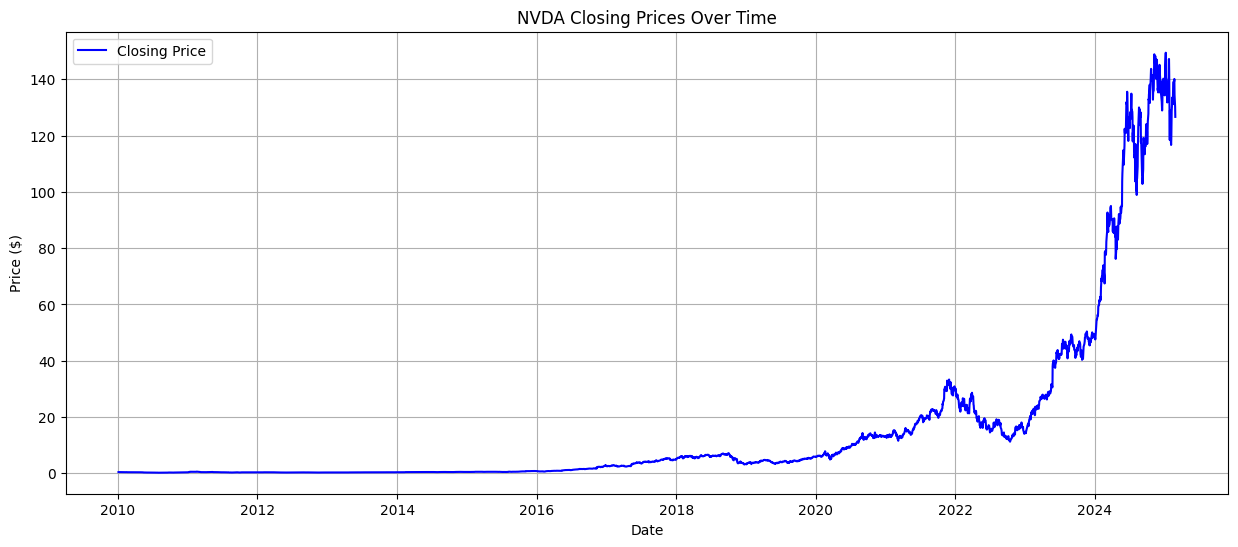

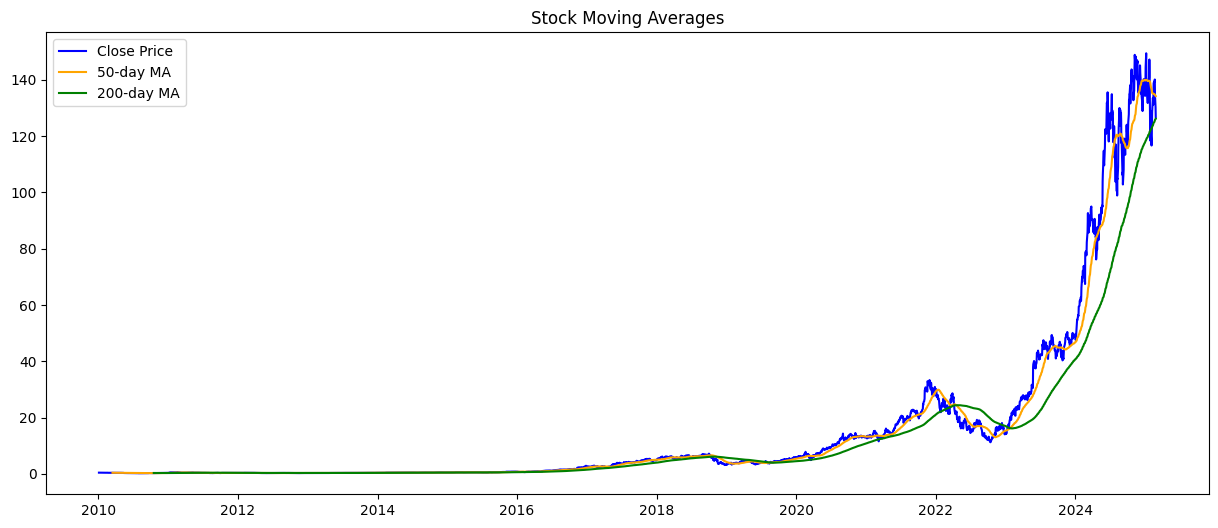

In [9]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 6))
plt.plot(stock['Close'], label='Closing Price', color='blue')
plt.title(f'{ticker} Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

# Moving Averages
stock['50_MA'] = stock['Close'].rolling(window=50).mean()
stock['200_MA'] = stock['Close'].rolling(window=200).mean()
plt.figure(figsize=(15, 6))
plt.plot(stock['Close'], label='Close Price', color='blue')
plt.plot(stock['50_MA'], label='50-day MA', color='orange')
plt.plot(stock['200_MA'], label='200-day MA', color='green')
plt.legend()
plt.title('Stock Moving Averages')
plt.show()

# Step 2: Data Preprocessing & Train/Test Data

In [21]:
print(stock.head())

# Prepare data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock[['Close']].values)

# Create sequences
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Split data
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455077  6.391279  6.422877  493729600
2010-01-05  6.451467  6.487880  6.417460  6.458087  601904800
2010-01-06  6.348847  6.477046  6.342227  6.451467  552160000
2010-01-07  6.337109  6.379843  6.291066  6.372319  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328684  447610800


# Step 4: Build the LR and LSTM Model

In [11]:
import joblib

print("\nTraining Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Save the Linear Regression model
lr_model_file = f'models/{ticker}_lr_model.pkl'
joblib.dump(lr_model, lr_model_file)
print(f"Linear Regression model saved as {lr_model_file}")

# Train LSTM model
print("\nTraining LSTM model...")
lstm_model = Sequential([
    Input(shape=(lookback, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='huber')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Save the LSTM model
lstm_model_file = f'models/{ticker}_lstm_model.h5'
lstm_model.save(lstm_model_file)
print(f"LSTM model saved as {lstm_model_file}")

# Save the scaler
scaler_file = f'models/{ticker}_scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"Scaler saved as {scaler_file}")


Training Linear Regression model...
Linear Regression model saved as models/NVDA_lr_model.pkl

Training LSTM model...
Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 6.7925e-05 - val_loss: 1.3279e-04 - learning_rate: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 4.2225e-06 - val_loss: 6.6214e-05 - learning_rate: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 3.5066e-06 - val_loss: 5.8363e-05 - learning_rate: 0.0010
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 2.5602e-06 - val_loss: 5.8120e-05 - learning_rate: 0.0010
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 2.5876e-06 - val_loss: 4.8462e-05 - learning_rate: 0.0010
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 1.9392e-06 - val_loss: 4.6881e-05 - learning_rate: 0.0010
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 1.8096e-06 - val_loss: 4.8101e-05 - learning_rate: 5.0000e-04
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s

LSTM model saved as models/NVDA_lstm_model.h5
Scaler saved as models/NVDA_scaler.pkl


# Step 5: Model Evaluation and Prediction

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

LR weight:  0.7607875961055586
LSTM weight:  0.23921240389444154

Model Evaluation:
Linear Regression - RMSE: 3.154668949022678, MAE: 2.3562269047899105, R²: 0.9890378886904851
LSTM - RMSE: 5.625921331403636, MAE: 4.3368273801909165, R²: 0.9651362631049538


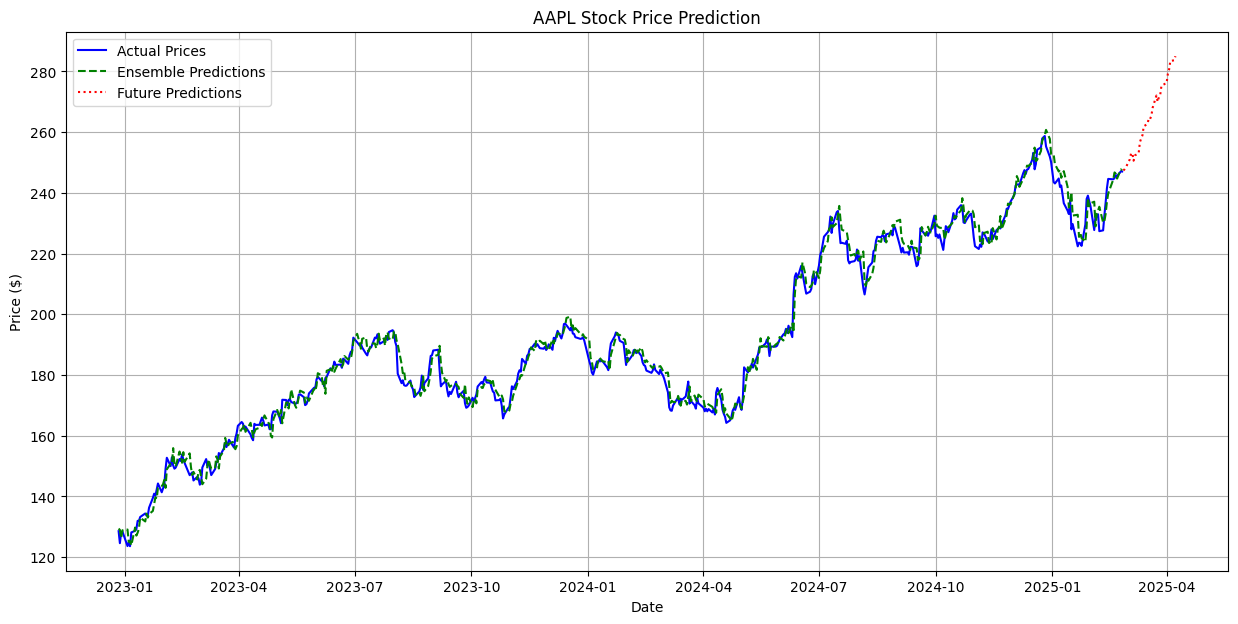

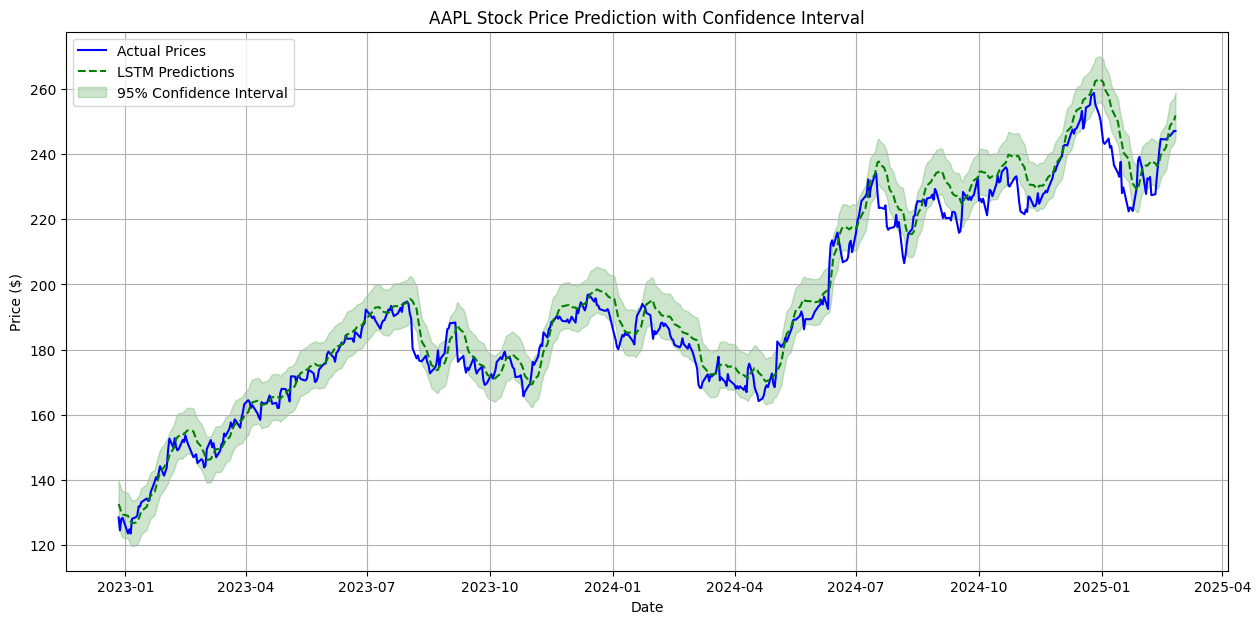

In [22]:
from tensorflow.keras.models import load_model

lr_model = joblib.load(f"models/{ticker}_lr_model.pkl")
lstm_model = load_model(f"models/{ticker}_lstm_model.h5")

# Make predictions
lr_pred = lr_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test_lstm)

# Inverse transform predictions
lr_pred = scaler.inverse_transform(lr_pred.reshape(-1, 1))
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate ensemble weights
lr_mse = mean_squared_error(actual_prices, lr_pred)
lstm_mse = mean_squared_error(actual_prices, lstm_pred)

total_mse = lr_mse + lstm_mse
lr_weight = 1 - (lr_mse / total_mse)
lstm_weight = 1 - (lstm_mse / total_mse)

print("\nLR weight: ", f"{lr_weight}\nLSTM weight: ", f"{lstm_weight}")

# Create ensemble predictions
ensemble_pred = lr_weight * lr_pred + lstm_weight * lstm_pred

# Model Evaluation
print("\nModel Evaluation:")
print(f"Linear Regression - RMSE: {np.sqrt(lr_mse)}, MAE: {mean_absolute_error(actual_prices, lr_pred)}, R²: {r2_score(actual_prices, lr_pred)}")
print(f"LSTM - RMSE: {np.sqrt(lstm_mse)}, MAE: {mean_absolute_error(actual_prices, lstm_pred)}, R²: {r2_score(actual_prices, lstm_pred)}")

# Future predictions
last_sequence = X_test[-1].reshape(1, lookback)
last_sequence_lstm = last_sequence.reshape(1, lookback, 1)

future_pred_lr, future_pred_lstm = [], []

for _ in range(future_days):
    future_lr = lr_model.predict(last_sequence).item()
    future_lstm = lstm_model.predict(last_sequence_lstm, verbose=0).item()
    weighted_pred = lr_weight * future_lr + lstm_weight * future_lstm
    
    future_pred_lr.append(future_lr)
    future_pred_lstm.append(future_lstm)
    
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = weighted_pred
    last_sequence_lstm = np.roll(last_sequence_lstm, -1, axis=1)
    last_sequence_lstm[0, -1, 0] = weighted_pred

future_pred_lr = scaler.inverse_transform(np.array(future_pred_lr).reshape(-1, 1))
future_pred_lstm = scaler.inverse_transform(np.array(future_pred_lstm).reshape(-1, 1))
future_pred_ensemble = lr_weight * future_pred_lr + lstm_weight * future_pred_lstm

# Plot predictions
plt.figure(figsize=(15, 7))
plt.plot(stock.index[-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
plt.plot(stock.index[-len(ensemble_pred):], ensemble_pred, label='Ensemble Predictions', color='green', linestyle='--')
plt.plot(pd.date_range(start=stock.index[-1], periods=future_days+1, freq='B')[1:], future_pred_ensemble, label='Future Predictions', color='red', linestyle=':')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

# Confidence interval calculations
errors = np.abs(actual_prices - lstm_pred)
confidence_interval = 1.96 * np.std(errors)  # 95% confidence interval
upper_bound = lstm_pred + confidence_interval
lower_bound = lstm_pred - confidence_interval

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(stock.index[-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
plt.plot(stock.index[-len(lstm_pred):], lstm_pred, label='LSTM Predictions', color='green', linestyle='--')
plt.fill_between(stock.index[-len(lstm_pred):], lower_bound.flatten(), upper_bound.flatten(), color='green', alpha=0.2, label='95% Confidence Interval')
plt.title(f'{ticker} Stock Price Prediction with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()